In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# Preprocessing

In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/밑바닥부터시작하는딥러닝2'
df = pd.read_csv(path + '/input/simpsons_dataset.csv')
df.shape

(158314, 2)

In [4]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [5]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [6]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

INFO - 03:32:07: NumExpr defaulting to 2 threads.


raw_character_text    0
spoken_words          0
dtype: int64

## Cleaning:

In [7]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [8]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [9]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.08 mins


In [10]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85964, 1)

In [11]:
df_clean.head()

,clean
0,actually little disease magazine news show nat...
2,know sure like talk touch lesson plan teach
3,life worth live
4,poll open end recess case decide thought final...
7,victory party slide


## Bigrams:

In [12]:
from gensim.models.phrases import Phrases, Phraser

INFO - 03:33:14: 'pattern' package not found; tag filters are not available for English


In [13]:
sent = [row.split() for row in df_clean['clean']]

In [14]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 03:33:14: collecting all words and their counts
INFO - 03:33:14: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 03:33:14: PROGRESS: at sentence #10000, processed 63561 words and 52816 word types
INFO - 03:33:14: PROGRESS: at sentence #20000, processed 130943 words and 99866 word types
INFO - 03:33:14: PROGRESS: at sentence #30000, processed 192972 words and 138532 word types
INFO - 03:33:14: PROGRESS: at sentence #40000, processed 249842 words and 172659 word types
INFO - 03:33:14: PROGRESS: at sentence #50000, processed 311265 words and 208566 word types
INFO - 03:33:14: PROGRESS: at sentence #60000, processed 373588 words and 243702 word types
INFO - 03:33:15: PROGRESS: at sentence #70000, processed 436441 words and 278740 word types
INFO - 03:33:15: PROGRESS: at sentence #80000, processed 497829 words and 311886 word types
INFO - 03:33:15: collected 330804 word types from a corpus of 537160 words (unigram + bigrams) and 85964 sentences
INFO - 03:33:15: us

In [15]:
bigram = Phraser(phrases)

INFO - 03:33:15: source_vocab length 330804
INFO - 03:33:18: Phraser built with 126 phrasegrams


In [16]:
sentences = bigram[sent]

In [17]:
print(sentences)

In [36]:
# skip-gram with negative sampling 용으로 여러 문장 연결
text_list = []
for sent in sentences:
  for word in sent:
    text_list.append(word)
print(text_list[:10])

['actually', 'little', 'disease', 'magazine', 'news', 'show', 'natural', 'think', 'know', 'sure']


## Most Frequent Words:

In [19]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

30178

In [20]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'right', 'look', 'want', 'come']

# Training the model

## Gensim Word2Vec

In [21]:
import multiprocessing

from gensim.models import Word2Vec

In [22]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [23]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [24]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 03:33:21: collecting all words and their counts
INFO - 03:33:21: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 03:33:22: PROGRESS: at sentence #10000, processed 61718 words, keeping 9558 word types
INFO - 03:33:22: PROGRESS: at sentence #20000, processed 127351 words, keeping 14506 word types
INFO - 03:33:22: PROGRESS: at sentence #30000, processed 187829 words, keeping 17619 word types
INFO - 03:33:22: PROGRESS: at sentence #40000, processed 243332 words, keeping 20385 word types
INFO - 03:33:22: PROGRESS: at sentence #50000, processed 303182 words, keeping 22878 word types
INFO - 03:33:23: PROGRESS: at sentence #60000, processed 363940 words, keeping 25200 word types
INFO - 03:33:23: PROGRESS: at sentence #70000, processed 425408 words, keeping 27401 word types
INFO - 03:33:23: PROGRESS: at sentence #80000, processed 485464 words, keeping 29275 word types
INFO - 03:33:23: collected 30178 word types from a corpus of 523700 raw words and 85964 sentence

Time to build vocab: 0.04 mins


In [ ]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [26]:
w2v_model.init_sims(replace=True)

INFO - 03:34:56: precomputing L2-norms of word weight vectors


In [45]:
query_word2vec = ['homer', 'homer_simpson', 'marge', 'bart']
for query in query_word2vec:
  print(w2v_model.wv.most_similar(positive=[query]))

[('bongo', 0.7850586175918579), ('marge', 0.7545016407966614), ('wife', 0.753163754940033), ('rude', 0.7520222663879395), ('snuggle', 0.7476695775985718), ('gee', 0.7444038391113281), ('sorry', 0.7389503121376038), ('attract', 0.7343780994415283), ('hammock', 0.7268487215042114), ('crummy', 0.723965585231781)]
[('congratulation', 0.7804332375526428), ('recent', 0.7683353424072266), ('council', 0.7683030366897583), ('fellow', 0.7558062076568604), ('governor', 0.7495534420013428), ('pleased', 0.744995653629303), ('committee', 0.7397987246513367), ('erotic', 0.739081621170044), ('waylon', 0.7356891632080078), ('hutz', 0.7339755296707153)]
[('convince', 0.7915847301483154), ('rude', 0.7670538425445557), ('sorry', 0.758787989616394), ('sure', 0.7579763531684875), ('attract', 0.7577086687088013), ('homer', 0.7545015811920166), ('hopeless', 0.753029465675354), ('arrange', 0.7486229538917542), ('grownup', 0.7477458715438843), ('hammock', 0.7432674169540405)]
[('lisa', 0.8490464687347412), ('su

## Skip-gram with Negative Sampling

In [28]:
# coding: utf-8

import sys
sys.path.append('/content/drive/Shareddrives/KU-BIG_2021-1_NLP_Study/input')
from common.layers import *
from ch04.negative_sampling_layer import NegativeSamplingLoss


class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None

| 에폭 1 |  반복 1 / 5236 | 시간 0[s] | 손실 41.59
| 에폭 1 |  반복 21 / 5236 | 시간 17[s] | 손실 41.59
| 에폭 1 |  반복 41 / 5236 | 시간 34[s] | 손실 41.59
| 에폭 1 |  반복 61 / 5236 | 시간 51[s] | 손실 41.57
| 에폭 1 |  반복 81 / 5236 | 시간 68[s] | 손실 41.49
| 에폭 1 |  반복 101 / 5236 | 시간 85[s] | 손실 41.22
| 에폭 1 |  반복 121 / 5236 | 시간 102[s] | 손실 40.73
| 에폭 1 |  반복 141 / 5236 | 시간 119[s] | 손실 39.96
| 에폭 1 |  반복 161 / 5236 | 시간 136[s] | 손실 38.93
| 에폭 1 |  반복 181 / 5236 | 시간 154[s] | 손실 38.01
| 에폭 1 |  반복 201 / 5236 | 시간 171[s] | 손실 37.37
| 에폭 1 |  반복 221 / 5236 | 시간 188[s] | 손실 36.33
| 에폭 1 |  반복 241 / 5236 | 시간 205[s] | 손실 35.48
| 에폭 1 |  반복 261 / 5236 | 시간 222[s] | 손실 35.06
| 에폭 1 |  반복 281 / 5236 | 시간 239[s] | 손실 34.68
| 에폭 1 |  반복 301 / 5236 | 시간 256[s] | 손실 34.13
| 에폭 1 |  반복 321 / 5236 | 시간 273[s] | 손실 33.81
| 에폭 1 |  반복 341 / 5236 | 시간 290[s] | 손실 33.24
| 에폭 1 |  반복 361 / 5236 | 시간 308[s] | 손실 32.66
| 에폭 1 |  반복 381 / 5236 | 시간 325[s] | 손실 32.65
| 에폭 1 |  반복 401 / 5236 | 시간 342[s] | 손실 32.28
| 에폭 1 |  반복 421 / 5236 | 

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

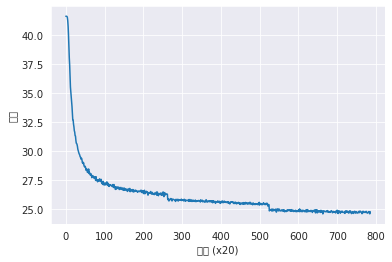

In [38]:
import sys 
sys.path.append('/content/drive/Shareddrives/KU-BIG_2021-1_NLP_Study/input')
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(쿠파이 필요).
# ======================================================
# config.GPU = True
# ======================================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 3

# corpus, word_to_id, id_to_word로 나누기
def preprocess(text_list):
  word_to_id = {}; id_to_word = {}
  for word in text_list:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word
  
  corpus = np.array([word_to_id[w] for w in text_list])

  return corpus, word_to_id, id_to_word

# 데이터 읽기
corpus, word_to_id, id_to_word = preprocess(text_list)
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
  contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
  word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
  pickle.dump(params, f, -1)


In [39]:
import sys
sys.path.append('/content/drive/Shareddrives/KU-BIG_2021-1_NLP_Study/input')
from common.util import most_similar
import pickle

pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
  params = pickle.load(f)
  word_vecs = params['word_vecs']
  word_to_id = params['word_to_id']
  id_to_word = params['id_to_word']

querys = ['homer', 'homer_simpson', 'marge', 'bart']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] homer
 mose: 0.74658203125
 tatupu: 0.7080078125
 counseling: 0.67041015625
 mindy: 0.66943359375
 straint: 0.646484375

[query] homer_simpson
 connor: 0.65771484375
 verge: 0.6171875
 musk: 0.5986328125
 plaque: 0.59814453125
 power_plant: 0.59375

[query] marge
 rine: 0.77001953125
 straint: 0.6865234375
 homie: 0.6611328125
 quirk: 0.6611328125
 loveless: 0.65087890625

[query] bart
 pigabar: 0.76953125
 mom_dad: 0.73095703125
 homework: 0.71142578125
 handful: 0.71044921875
 earre: 0.67578125


# t-SNE Visualization

In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [41]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

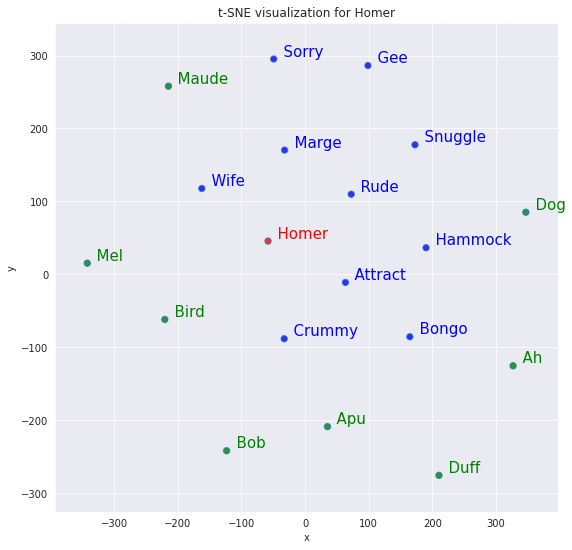

In [42]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])